In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle as pk
from smt.sampling_methods import LHS
from multiprocessing import Pool
import multiprocessing
# from my_model import mymf
import sys
import os
import numpy as np
import matplotlib as mpl
import pickle as pk
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import shutil
from IPython.display import clear_output
from time import sleep
import h5py
# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
from flopy.utils.util_array import read1d
mpl.rcParams['figure.figsize'] = (8, 8)
from TCP3d_model import mymf
from para_simu import simu
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))
exe_name_mf = '/Users/zitongzhou/Downloads/pymake/examples/mf2005'
exe_name_mt = '/Users/zitongzhou/Downloads/pymake/examples/mt3dms'
# annots = loadmat("/Volumes/GoogleDrive/My Drive/inverse_modeling/reactive_transport/kd.mat")
# annots.keys()

# kle = annots['kle_terms']
# K = annots['K']

3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.19.2
matplotlib version: 3.3.1
flopy version: 3.3.2


In [3]:
os.getcwd()

'/Users/zitongzhou/Desktop/react_inverse/TCP_3d'

In [ ]:
if __name__ == '__main__':
    exe_name_mf = '/Users/zitongzhou/Downloads/pymake/examples/mf2005'
    exe_name_mt = '/Users/zitongzhou/Downloads/pymake/examples/mt3dms'
    os.chdir('/Volumes/GoogleDrive/My Drive/react_inverse/simu_inputs/')
    for i in range(5):
        start = time.time()
        filename = 'input_'+str(i)+'.hdf5'
        conc, heads = simu(filename)
        print(time.time() - start)

In [23]:
def well_plot(c_map, title,  wel = None, obs = None, ):
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250
    dx = Lx/(nx-1)
    dy = Ly/(ny-1)


    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)
    fig, axs = plt.subplots(1,1)
#        axs.set_xlabel('x(m)')
#        axs.set_ylabel('y(m)')
    axs.set_xlim(0,Lx)
    axs.set_ylim(0,Ly)
    c01map = axs.imshow(c_map, cmap='jet',
              extent=[x.min(), x.max(), y.min(), y.max()],
              vmin=c_map.min(), vmax = c_map.max(),
              origin='lower')
    if wel:

        axs.scatter(wel["x"], wel["y"],  c = "blue", label='candidate release')
        for wel_x in wel['x']:
            axs.vlines(wel_x+100, 0, Ly, linestyles='dashed')
        for wel_y in wel['y']:
            axs.hlines(wel_y+(wel['y'][1] - wel['y'][0])/2, 0, wel['x'][-1]+100, linestyles='dashed')
    if obs:
        
        axs.scatter(obs["x"], obs["y"], c = 'red', label = 'sensor')
        
#        CS = axs.contour(head, levels = np.arange(0, 10.5, 0.5), origin='lower', cmap='flag',
#                linewidths=2, extent=[x.min(), x.max(), y.min(), y.max()],)
    fig.colorbar(c01map, ax=axs,shrink=0.48)
    name = title + '.png'
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='lower right')
    fig.savefig('/Users/zitongzhou/Desktop/react_inverse/images/'+name, format='png',bbox_inches='tight')
    plt.show()
    return

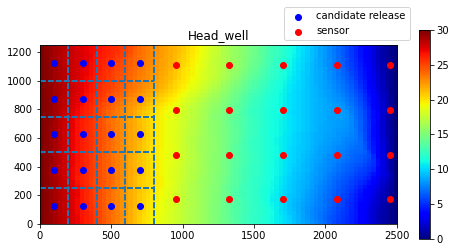

In [24]:
### wells and sensors

y_wel = np.array([125, 125*3, 125*5, 125*7, 125*9,
        125, 125*3, 125*5, 125*7, 125*9,
        125, 125*3, 125*5, 125*7, 125*9,
        125, 125*3, 125*5, 125*7, 125*9,]) # #np.random.randint(low = 5, high = 35, size = 20)
x_wel = np.array([100, 100, 100, 100, 100, 
         300, 300, 300, 300, 300,
         500, 500, 500, 500, 500,
         700, 700, 700, 700, 700])# #np.random.randint(low = 0, high = 25, size = 20)
# wells = {i: [y_wel[i], x_wel[i]] for i in range(len(y_wel))}

np.random.seed(888)
# y_obs = np.random.randint(low = 5, high = 35, size = 20)
# x_obs = np.random.randint(low = 30, high = 80, size = 20)
y_obs = np.linspace(5, 35, num=4).astype('int')
x_obs = np.linspace(30, 78, num=5).astype('int')
y_obs, x_obs = np.meshgrid(y_obs, x_obs)

f = h5py.File('/Users/zitongzhou/Desktop/react_inverse/TCP_3d/output_0.hdf5', 'r')
head = np.array(f["head"])[3]
f.close()  # close the file object for the next run


# head = np.flip(head, 0)
dx = 2500/80
dy = 1250/40
wel = {'x': x_wel, 'y': y_wel}
# wel = {"x": list(dx/2 + x_wel*dx), "y": list(dy/2 + y_wel*dy)}
obs = {"x": list(dx/2 + x_obs*dx), "y": list(dy/2 + y_obs*dy)}
well_plot(head, 'Head_well',wel, obs)

In [17]:
np.linspace(30, 78, num=5).astype('int')

array([30, 42, 54, 66, 78])

## Parallel simulation

In [8]:
if __name__ == '__main__':
#     for n_pool in range(1, multiprocessing.cpu_count()):
    n_pool = 5
    pool = Pool(n_pool)
    cwd = '/Users/zitongzhou/Desktop/simu_inputs.tmp/'
    filelist = os.listdir(cwd)
    filelist = [file for file in filelist if file.endswith('.hdf5')]
#     filelist = filelist[:5]
    os.chdir(cwd)
    start = time.time()
    pool.map(simu, filelist)
    print(n_pool)
    print('parallel sampling time:',time.time() - start)
    print('number of simulations:', len(filelist))

5
parallel sampling time: 9444.728926897049
number of simulations: 1000
